In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from sklearn.preprocessing import MinMaxScaler

In [2]:
general_path = 'C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/'

In [3]:
model_paths = ['LSTM/BASELINE_GRU_best_model_thresholds_grid_search.tsv', 
               'MOVING AVERAGE/MA_best_model_thresholds_grid_search.tsv', 
               'STL DECOMPOSITION/LOWESS_best_model_thresholds_grid_search.tsv', 
               'VAE2/MLP/MLP_best_model_thresholds_grid_search.tsv', 
               'VAE2/CNN/CNN_best_model_thresholds_grid_search.tsv',
               'VAE2/LSTM/GRU_best_model_thresholds_grid_search.tsv']
model_names = ['GRU Network', 'MA Model', 'LOWESS Model', 'Dense VAE', 'CNN VAE', 'GRU VAE']

# Heat Maps

In [127]:
def plot_metric(AA, BB, CC, file_path, j):
    def f(AA, BB):
        C = np.zeros((len(AA), len(BB)))
        for i in range(len(AA)):
            for j in range(len(BB)):
                C[i, j] = CC[(AA[i], BB[j])]
        return C    
    A, B = np.meshgrid(AA, BB)
    C = f(AA, BB)
        
    max_val = np.max(C)
    x, y = np.where(C == max_val)
    max_val_x = A[x[0], x[0]]
    max_val_y = B[y[0], y[0]]
    
    ax = axes[floor(j/2)][j%2]
#     fig, ax = plt.subplots(figsize=(12,8))
    levels = np.linspace(0, 0.7, 91)
    ret = ax.contourf(A, B, C, levels=levels, cmap='jet')
    if j % 2 == 0:
        ax.set_ylabel('Average Threshold')
    if j > 3:
        ax.set_xlabel('Direct Threshold')
#     plt.colorbar()
    ax.scatter([max_val_y], [max_val_x], marker='o', facecolors='none', s=50, edgecolors='black')
    if 'LSTM' in file_path:
        ax.annotate(max_val, (max_val_y - 0.07, max_val_x + 0.04))
        ax.annotate(f'({max_val_y}, {max_val_x:.2f})', (max_val_y - 0.115, max_val_x - 0.06))
    else:
        ax.annotate(max_val, (max_val_y - 0.016, max_val_x + 0.0075))
        ax.annotate(f'({max_val_y:.3f}, {max_val_x:.3f})', (max_val_y - 0.031, max_val_x - 0.013))
    return ret
    
def load_metric_and_plot(file_path, metric_name, j):
    metrics = pd.read_csv(file_path, delimiter='\t', index_col=False)
    direct_thresholds = sorted(metrics['Direct Threshold'].unique())
    average_thresholds = sorted(metrics['Averaged Threshold'].unique())
    selected_metric = dict()
    for index, row in metrics.iterrows():
        selected_metric[(row['Direct Threshold'], row['Averaged Threshold'])] = row[metric_name]
    return plot_metric(direct_thresholds, average_thresholds, selected_metric, file_path, j)

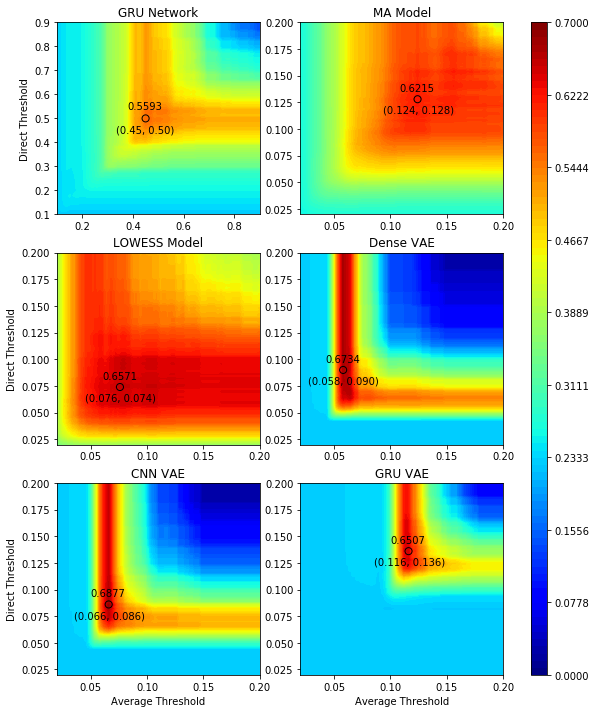

In [71]:
fig, axes = plt.subplots(3, 2, figsize=(10,12))
# fig.suptitle("Manually Labeled Timeseries")
for j, name in zip(range(len(model_paths)), model_names):
    metrics = pd.read_csv(general_path + model_paths[j], delimiter='\t', index_col=False)
    AA = sorted(metrics['Direct Threshold'].unique())
    BB = sorted(metrics['Averaged Threshold'].unique())
    CC = dict()
    for index, row in metrics.iterrows():
        CC[(row['Direct Threshold'], row['Averaged Threshold'])] = row["Red F1"]
    
    
    def f(AA, BB):
        C = np.zeros((len(AA), len(BB)))
        for i in range(len(AA)):
            for j in range(len(BB)):
                C[i, j] = CC[(AA[i], BB[j])]
        return C    
    A, B = np.meshgrid(AA, BB)
    C = f(AA, BB)
        
    max_val = np.max(C)
    x, y = np.where(C == max_val)
    max_val_x = A[x[0], x[0]]
    max_val_y = B[y[0], y[0]]
    
    ax = axes[floor(j/2)][j%2]
#     fig, ax = plt.subplots(figsize=(12,8))
    levels = np.linspace(0, 0.7, 91)
    ax.set_title(name)
    ret = ax.contourf(A, B, C, levels=levels, cmap='jet')
    if j % 2 == 0:
        ax.set_ylabel('Direct Threshold')
    if j > 3:
        ax.set_xlabel('Average Threshold')
#     plt.colorbar()
    ax.scatter([max_val_y], [max_val_x], marker='o', facecolors='none', s=50, edgecolors='black')
    if 'BASELINE_GRU' in (general_path + model_paths[j]):
        ax.annotate(max_val, (max_val_y - 0.07, max_val_x + 0.04))
        ax.annotate(f'({max_val_y}, {max_val_x:.2f})', (max_val_y - 0.115, max_val_x - 0.06))
    else:
        ax.annotate(max_val, (max_val_y - 0.016, max_val_x + 0.0075))
        ax.annotate(f'({max_val_y:.3f}, {max_val_x:.3f})', (max_val_y - 0.031, max_val_x - 0.013))
    

fig.colorbar(ret, ax=axes, aspect=40)
fig.savefig('heat_maps.png', bbox_inches='tight', pad_inches=0.5)

# Timeseries Classification Errors

In [4]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [5]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

BP_data_orig = BP_data.iloc[1:].astype(np.float32).copy()
HR_data_orig = HR_data.iloc[1:].astype(np.float32).copy()

In [6]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(64).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(64).mean()

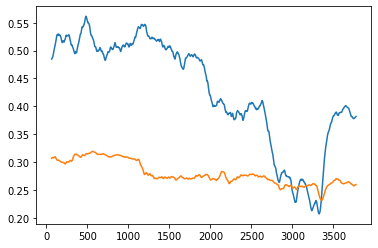

In [7]:
plt.plot(BP_data_scaled_averaged['1'])
plt.plot(HR_data_scaled_averaged['1'])

In [8]:
# SMOOTHING
BP_data_orig_averaged = BP_data_orig.rolling(64).mean()
HR_data_orig_averaged = HR_data_orig.rolling(64).mean()

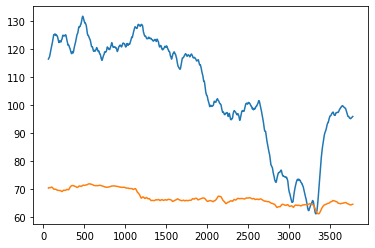

In [9]:
plt.plot(BP_data_orig_averaged['1'])
plt.plot(HR_data_orig_averaged['1'])

In [10]:
# indexes = ['1', '92', '110', '158', '286', '295', '375', '393', '460', '501', '606', '658', '675']
indexes = ['393', '92', '675', '460', '110', '1']
# 675          - spadek czerwonego
# 92           - spadek niebieskiego
# 375 albo 393 - spadek obu
# 460          - spadek jednego i wzrost drugiego
# 110          - nic sie nie dzieje
# 1            - powolny spadek czerwonego

In [11]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [12]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 108, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 142, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
# index = '158' 
# label_func('158', 25, 29, 'r')
# label_func('158', 115, 116, 'r')
# label_func('158', 116, 122, 'r')
# label_func('158', 122, 123, 'r')
# index = '286' 
# label_func('286', 63, 65, 'r')
# label_func('286', 65, 67, 'r')
# label_func('286', 123, 124, 'r')
# label_func('286', 124, 129, 'r')
# label_func('286', 129, 131, 'r')
# label_func('286', 131, 134, 'r')
# index = '295' 
# label_func('295', 131, 134, 'r')
# label_func('295', 134, 144, 'r')
# index = '375'
# label_func('375', 40, 47, 'r')
# label_func('375', 129, 133, 'r')
# label_func('375', 133, 141, 'r')
# label_func('375', 141, 144, 'r')
# label_func('375', 162, 167, 'r')
index = '393' 
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '460' 
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
# index = '501'
# label_func('501', 119, 120, 'r')
# label_func('501', 120, 124, 'r')
# label_func('501', 124, 125, 'r')
# index = '606'
# label_func('606', 60, 61, 'r')
# label_func('606', 61, 70, 'r')
# label_func('606', 70, 72, 'r')
# index = '658', 
# label_func('658', 36, 53, 'r')
# label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

In [13]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

In [14]:
model_general_paths = ['LSTM/', 
                       'MOVING AVERAGE/', 
                       'STL DECOMPOSITION/', 
                       'VAE2/MLP/', 
                       'VAE2/CNN/',
                       'VAE2/LSTM/']
file_name = 'best_model_best_params_predicted_labels.tsv'

In [15]:
import matplotlib.patches as mpatches

<Figure size 432x288 with 0 Axes>

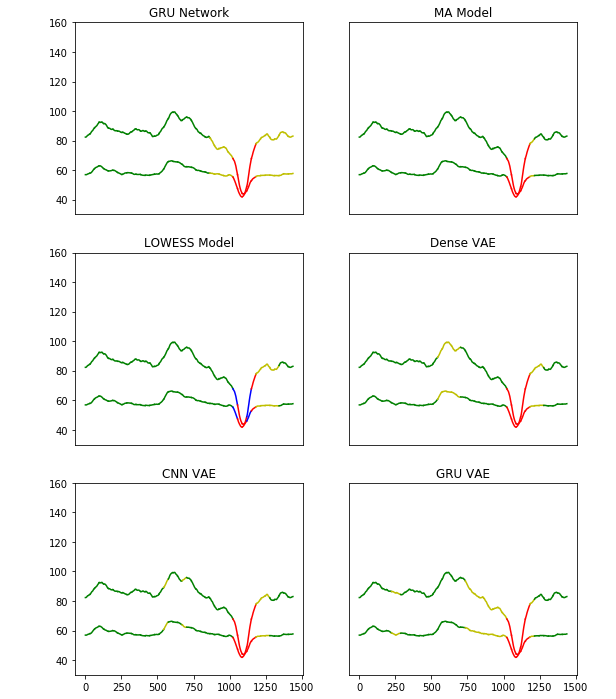

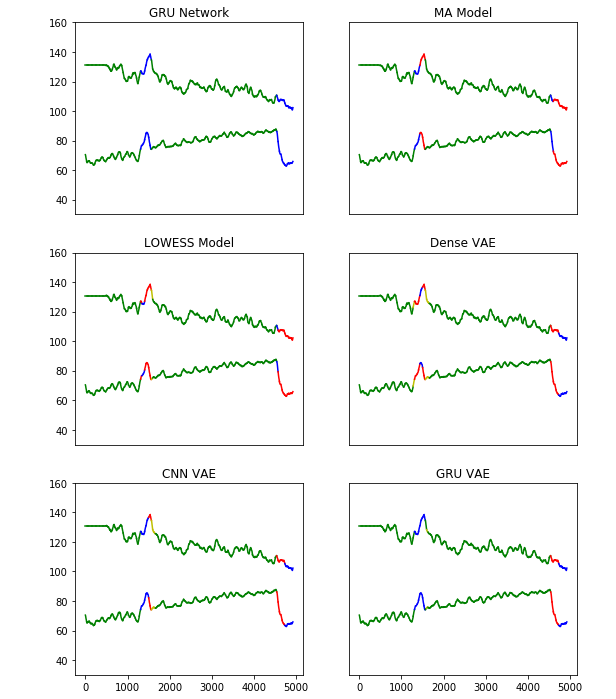

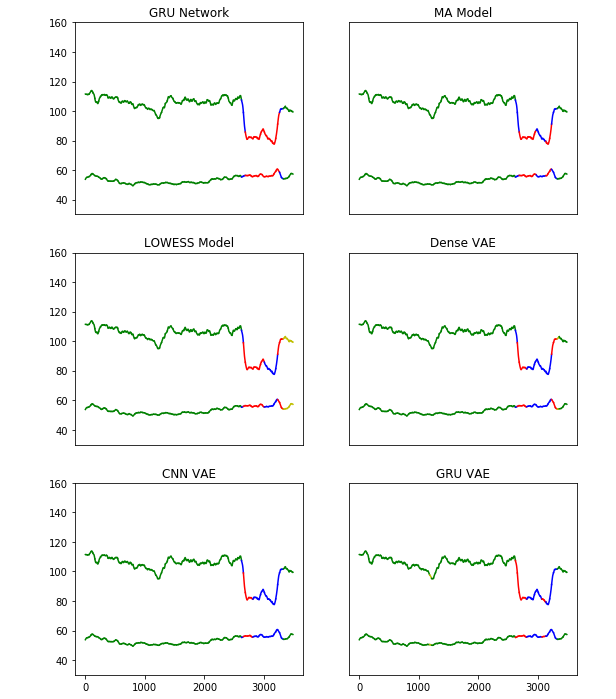

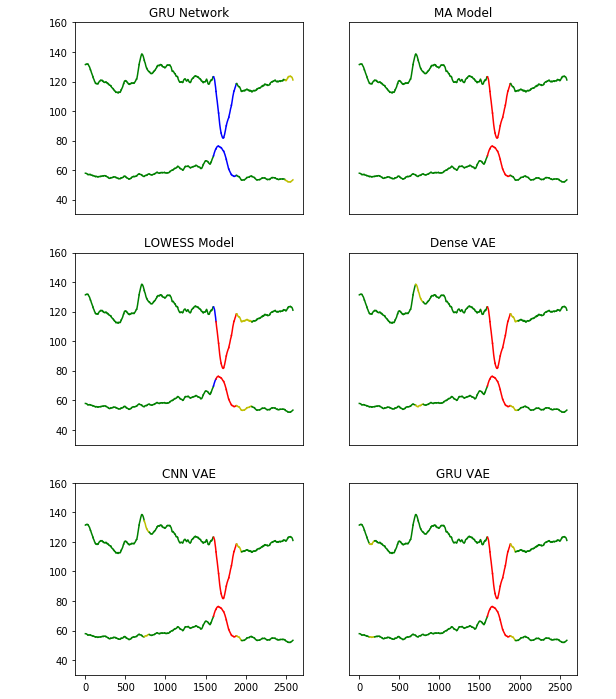

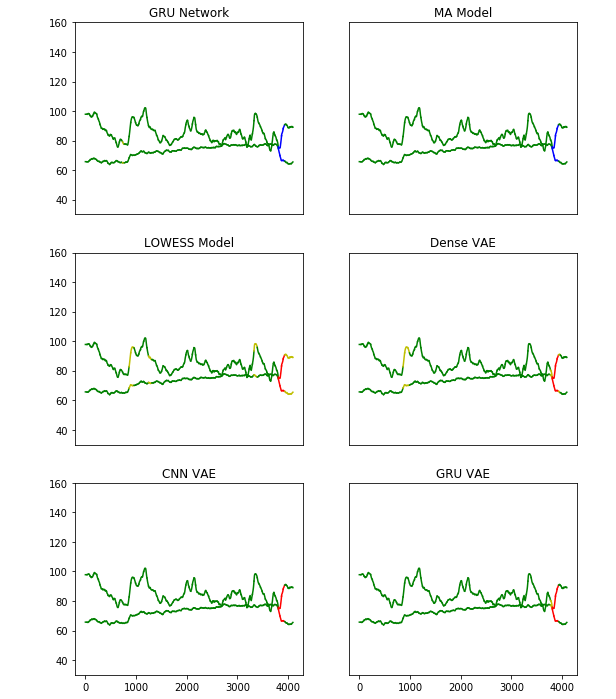

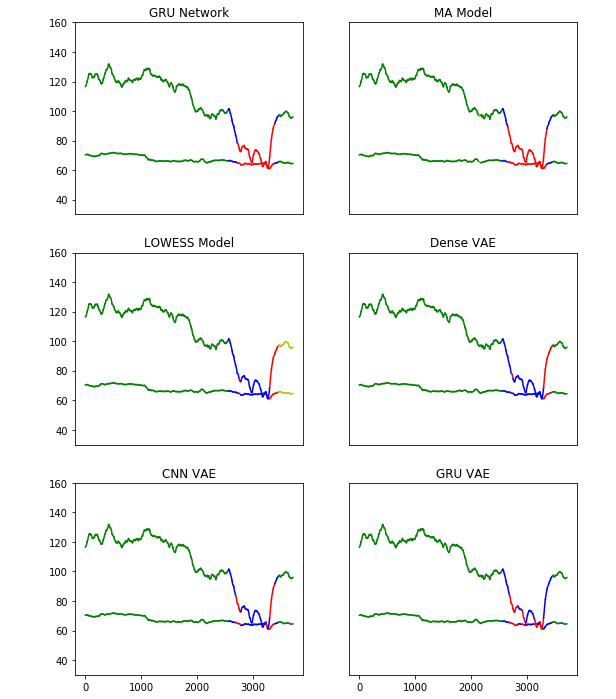

In [16]:
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
for index in indexes:
    fig, axes = plt.subplots(3, 2, figsize=(9,12))
    labels_true = BP_HR_validation_labels[str(index)]
    HR = sample_timeseries(HR_data_orig_averaged[str(index)])
    BP = sample_timeseries(BP_data_orig_averaged[str(index)])
    n_of_samples = len(BP)

    #     labels = ['True Positive', 'True Negative', 'False Positive (Type 1 Error)', 'False Negative (Type 2 Error)']
    labels = ['True Positive', 'True Negative', 'False Positive (Type 1 Error)', 'False Negative (Type 2 Error)']

    leg1 = mpatches.Patch(color='r')
    leg2 = mpatches.Patch(color='g')
    leg3 = mpatches.Patch(color='y')
    leg4 = mpatches.Patch(color='b')

    # bboc_to_anchor = (0.5, 0.95) dla ulozenia na gorze
    # bboc_to_anchor = (0.5, 0.1) dla ulozenia na dole
    fig.legend(ncol=4, 
               handles=[leg1, leg2, leg3, leg4], 
               labels=labels, loc="upper center", 
               bbox_to_anchor=(0.485, 0.88),
               frameon=False)
    
    for i, name in zip(range(len(model_paths)), model_names):
        all_pred_labels = pd.read_csv(general_path + model_general_paths[i] + file_name, delimiter='\t', index_col=False)
        pred_labels = all_pred_labels[str(index)].tolist()
        ax = axes[floor(i/2)][i%2]
        ax.set_title(name)
        ax.set_ylim(30, 160)
        if i % 2 != 0:
            ax.yaxis.set_visible(False)
        if i <= 3:
            ax.xaxis.set_visible(False)

        BP_last_elem = None
        t = 0
#         print(f"N:{n_of_samples}")
#         print(f"PRED:{len(pred_labels)}")

        for HRv, BPv, j in zip(HR, BP, range(n_of_samples)):
            label_pred = pred_labels[j]
            if labels_true[j] == 'g' and labels_true[j] == label_pred:
                label = 'g'
            elif labels_true[j] == 'g' and labels_true[j] != label_pred:
                label = 'y'
            elif labels_true[j] == 'r' and labels_true[j] == label_pred:
                label = 'r'
            elif labels_true[j] == 'r' and labels_true[j] != label_pred:
                label = 'b'

            if BP_last_elem == None:
                ax.plot(range(t, t + len(HRv)), HRv, color=f'{label}', linestyle='-')
                ax.plot(range(t, t + len(BPv)), BPv, color=f'{label}', linestyle='-')
                t += len(BPv)
            else:
                time_range = range(t-1, t + len(BPv)) 
                BPv = np.concatenate(([BP_last_elem], BPv))
                HRv = np.concatenate(([HR_last_elem], HRv))
                ax.plot(time_range, HRv, color=f'{label}', linestyle='-')
                ax.plot(time_range, BPv, color=f'{label}', linestyle='-')
                t += len(BPv) - 1
            BP_last_elem = BPv[-1]
            HR_last_elem = HRv[-1] 
    fig.savefig(f'{index}_timeseries_prediction_errors.png', bbox_inches='tight', pad_inches=0.5)

In [44]:
3 >= 3

True